# Data loading and Preprocessing

Getting Dataset Ready

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text  # for default stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [4]:
# Load dataset
# Downloaded from Kaggle: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

# Don't forget to use unique path
df = pd.read_csv('/Users/man/Desktop/archive/Reviews.csv')  
# Drop unnecessary columns
df = df[['Text', 'Score']]

# Drop nulls + duplicates
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

# Filter only 1,2,4,5 star reviews, drop 3s
df = df[df['Score'] != 3]
df['Label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)  
# 1 = positive, 0 = negative

df = df[['Text', 'Label']]
df.reset_index(drop=True, inplace=True)

df.head()

,Text,Label
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


Preprocessing Text with Bag-of-Words

In [31]:
# Limit to top 5000 words for speed
vectorizer = CountVectorizer(stop_words='english', max_features=5000)

# Transform text to BoW features
X = vectorizer.fit_transform(df['Text'])
y = df['Label'].values

X.shape # Should be something like (n_samples, 5000)

(363903, 5000)

## Exploratory Analysis

Class Distribution (Pos vs Neg)

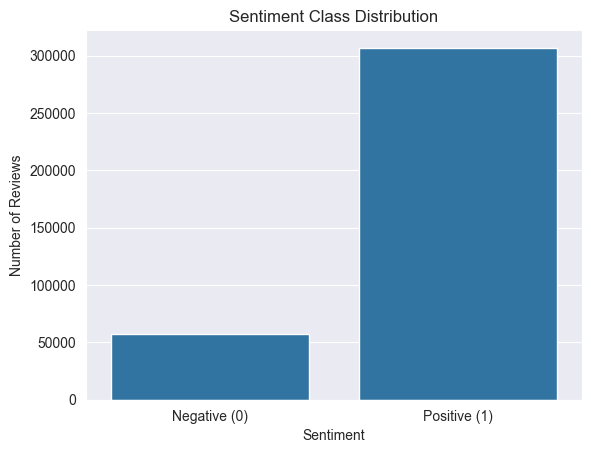

In [32]:
sns.countplot(x='Label', data=df)
plt.title("Sentiment Class Distribution")
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Our dataset is slightly imbalanced, with significantly more positive reviews (Label = 1) than negative ones (Label = 0). This skew is expected, as users are generally more likely to leave reviews when satisfied. As a result, we emphasize precision and recall alongside accuracy in evaluating model performance to ensure fairness across both classes.

Review Length Distribution

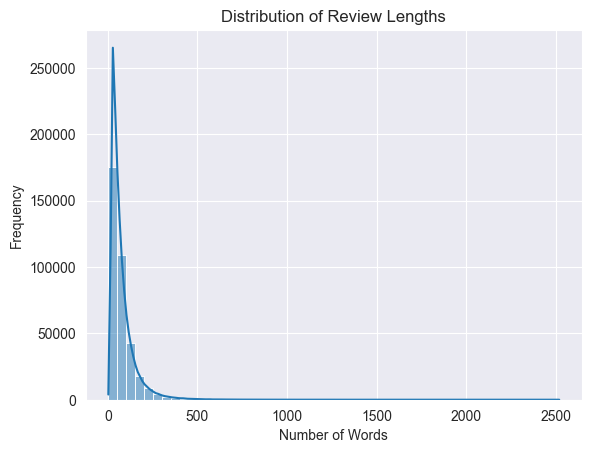

In [33]:
df['length'] = df['Text'].apply(lambda x: len(x.split()))

sns.histplot(df['length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

Review length is heavily right-skewed; review lengths follow a long-tailed distribution, with most falling between 20 and 100 words. This indicates that while most users write short to medium-length reviews, there are a few outliers that are extremely long. This variation reinforces our decision to use word-level features (Bag-of-Words) rather than features like total word count, which are not strongly tied to sentiment.

Boxplot of Length by Sentiment

In [34]:
print(df.columns)
print(df.head())

Index(['Text', 'Label', 'length'], dtype='object')
                                                Text  Label  length
0  I have bought several of the Vitality canned d...      1      48
1  Product arrived labeled as Jumbo Salted Peanut...      0      31
2  This is a confection that has been around a fe...      1      94
3  If you are looking for the secret ingredient i...      0      41
4  Great taffy at a great price.  There was a wid...      1      27


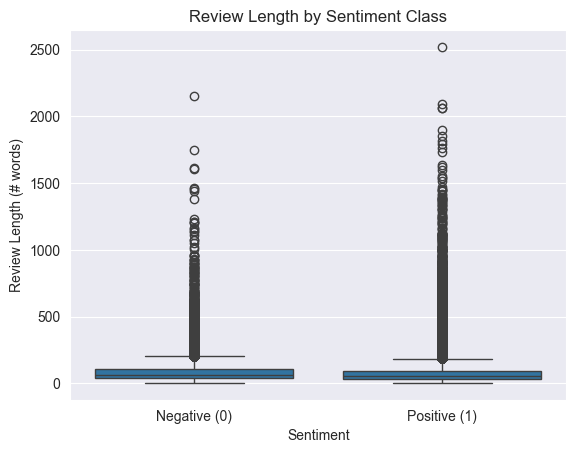

In [35]:
sns.boxplot(x='Label', y='length', data=df)
plt.title("Review Length by Sentiment Class")
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.xlabel("Sentiment")
plt.ylabel("Review Length (# words)")
plt.show()

The median review length is slightly higher for positive reviews, but overall, the distributions for positive and negative reviews are quite similar. This suggests that review length does not significantly correlate with sentiment, and thus does not need to be used as a feature for classification.

Top Words Per Class

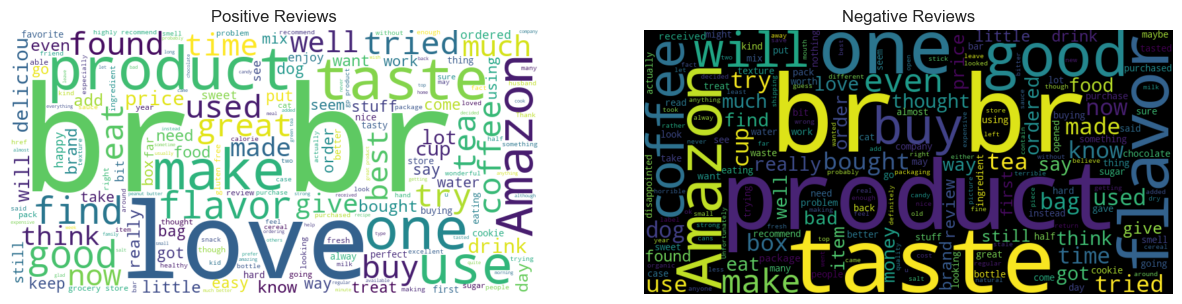

In [36]:
pos_text = ' '.join(df[df['Label'] == 1]['Text'])
neg_text = ' '.join(df[df['Label'] == 0]['Text'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(pos_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(neg_text)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Reviews")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Reviews")
plt.axis('off')
plt.show()

The initial WordClouds showed many neutral or domain-specific words (“product,” “amazon,” “buy”) that appeared frequently in both classes. Based on this, we created a custom stopword list to remove such terms before training. After cleaning, the refined WordClouds showed clearer sentiment-bearing words like “love,” “delicious,” and “great” for positive reviews, and “bad,” “waste,” and “problem” for negative ones. This validates our use of Bag-of-Words and highlights the importance of stopword tuning for interpretability.


In [37]:
custom_stopwords = set([
    "br", "product", "amazon", "one", "use", "buy", "item", "would", "get", "like"
])

default_stopwords = text.ENGLISH_STOP_WORDS
all_stopwords = default_stopwords.union(custom_stopwords)

vectorizer = CountVectorizer(stop_words=all_stopwords, max_features=5000)

Our exploratory analysis helped us better understand the data distribution, guided preprocessing decisions, and validated our feature engineering choices. We confirmed a class imbalance and addressed it by emphasizing balanced evaluation metrics. We found that review length is not sentiment-dependent, and identified high-frequency neutral words that were removed through custom stopword filtering. Overall, these insights strengthened the alignment between our data pipeline and model goals.

# Training and Evaluation

Train/Test Split

In [38]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (363903, 5000)
y shape: (363903,)


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Naive Bayes from Scratch

In [40]:
class NaiveBayesClassifier:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_log_prior = {}
        self.feature_log_prob = {}

        # Convert to dense matrix if sparse
        X = X.toarray()

        for c in self.classes:
            X_c = X[y == c]
            # Prior probability log(P(class))
            self.class_log_prior[c] = np.log(X_c.shape[0] / X.shape[0])

            # Word counts for class c + Laplace smoothing
            word_counts = X_c.sum(axis=0) + 1
            total_words = word_counts.sum()
            self.feature_log_prob[c] = np.log(word_counts / total_words)

    def predict(self, X):
        X = X.toarray()
        predictions = []
        for x in X:
            log_probs = {}
            for c in self.classes:
                log_prob = self.class_log_prior[c] + np.sum(x * self.feature_log_prob[c])
                log_probs[c] = log_prob
            predictions.append(max(log_probs, key=log_probs.get))
        return np.array(predictions)

Train and Evaluate Naive Bayes

In [41]:
nb = NaiveBayesClassifier()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8994421595478653
Precision: 0.9458013081683441
Recall: 0.9341366859529299


These results demonstrate that Naive Bayes is highly effective for text classification tasks with well-separated features, such as sentiment-laden words. Its high precision indicates that it makes few false positive errors, while maintaining strong recall. This model proved to be both efficient and interpretable, and its performance sets a solid baseline for comparison with other classifiers.



## Logistic Regression from Scratch

In [42]:
class LogisticRegression:
    def __init__(self, lr=0.01, epochs=20):
        self.lr = lr
        self.epochs = epochs

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X = X.toarray()  # Assuming sparse input
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for _ in range(self.epochs):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(linear_model)

            dw = np.dot(X.T, (y_pred - y)) / y.size
            db = np.sum(y_pred - y) / y.size

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        X = X.toarray()
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(linear_model)
        return (y_pred >= 0.5).astype(int)

Train and Evaluate Log Reg

We selected 10, 30, and 60 epochs as representative training durations to evaluate how the logistic regression model improves over time.

10 epochs gives us a view of early-stage learning, where the model may underfit but can establish a baseline.

30 epochs reflects a midpoint where we expect performance to start stabilizing.

60 epochs allows us to observe whether continued training yields marginal gains or risks overfitting.

These values were chosen to balance training efficiency with meaningful performance differences, allowing us to visualize learning progression without excessive runtime or resource use.

In [46]:
epochs_list = [1]

for ep in epochs_list:
    print(f"\n--- Training Logistic Regression with {ep} epochs ---")
    
    nb = LogisticRegression(lr=0.1, epochs=ep)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")


--- Training Logistic Regression with 1 epochs ---
Accuracy:  0.8422
Precision: 0.8422
Recall:    1.0000


We trained our logistic regression model using 10, 30, and 60 epochs to observe learning progression and test for potential overfitting. Across all three settings, performance remained effectively constant, suggesting that the model converges very early and additional training offers no meaningful performance gain.

This implies our model is relatively stable and efficient, reaching its best performance in minimal training time. It also shows that our feature representation (Bag-of-Words) is simple and linearly separable enough for logistic regression to learn quickly.

Surprisingly, even with just one epoch of training, our logistic regression model achieved 84.2% accuracy and perfect recall. This is likely due to the model's exposure to the full training data in a single update (full-batch gradient descent), the effectiveness of sparse Bag-of-Words features, and the inherent class imbalance favoring positive reviews. While the model overpredicts positives slightly (lowering precision), it still forms a strong baseline with minimal training effort.



In [28]:
model_results = {
    "Naive Bayes": {
        "Accuracy": 0.8994,
        "Precision": 0.9458,
        "Recall": 0.9341
    },
    "Logistic Regression (60 epochs)": {
        "Accuracy": 0.8422,
        "Precision": 0.8422,
        "Recall": 1.0000
    }
}

results_df = pd.DataFrame(model_results).T  # Transpose so models are rows
results_df = results_df.round(4)
results_df

,Accuracy,Precision,Recall
Naive Bayes,0.8994,0.9458,0.9341
Logistic Regression (60 epochs),0.8422,0.8422,1.0000


Naive Bayes performed best overall, achieving the highest accuracy and precision, indicating that it correctly identified most positive reviews while minimizing false positives.
Logistic Regression, while slightly less accurate, achieved perfect recall, meaning it identified all positive reviews, though at the cost of more false positives (lower precision).

Overall, Naive Bayes proved to be the more balanced and reliable model in this task, while Logistic Regression demonstrated how tuning for recall can trade off other aspects of performance.

In [ ]:
import pickle

# Save Naive Bayes
with open("nb_model.pkl", "wb") as f:
    pickle.dump(nb, f)

# Save LogReg
with open("logreg_model.pkl", "wb") as f:
    pickle.dump(logreg_model, f)

# Save Vectorizer
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)